# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [3]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = "https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=train.zip"
output_zip = "train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=val.zip"
output_zip = "val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=test_public.zip"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From: https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=train.zip
To: /content/train.zip
100%|██████████| 439M/439M [00:19<00:00, 22.6MB/s]
Downloading...
From: https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=val.zip
To: /content/val.zip
100%|██████████| 87.8M/87.8M [00:04<00:00, 18.3MB/s]
Downloading...
From: https://drive.switch.ch/index.php/s/EvcJ50qHiN0KO7l/download?path=%2F&files=test_public.zip
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:04<00:00, 18.9MB/s]


## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [4]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth
            }

## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DrivingPlanner(nn.Module):
    def __init__(self, use_depth_aux=False):
        super().__init__()
        self.use_depth_aux = use_depth_aux

        # Visual encoder: ResNet18 pretrained
        # net = models.resnet18(pretrained=True)
        net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.visual_net = nn.Sequential(*list(net.children())[:-2]) # Remove final layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1)) # 1280xWxH -> 1280x1x1
        self.visual_encoder = nn.Sequential(
            nn.Linear(1280, 256), # 1280 -> 256
            nn.LeakyReLU()
        )

        # Decoder for trajectory prediction
        self.trajectory_encoder = nn.Sequential(
            nn.Linear(21*3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU()
        )

        # CNN for depth encoder
        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 200x300x1 -> 200x300x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # Divides size by 2: 200x300x32 -> 100x150x32
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # 100x150x32 -> 50x75x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2), # 50x75x64 -> 25x38x64
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(25*38*64, 256),
            nn.LeakyReLU(),
        )

        # Future trajectory fuser and decoder
        self.decoder = nn.Sequential(
            nn.Linear(256 + 128 + 256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 60*3)
        )

        # Optional depth decoder
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.ConvTranspose2d(1280, 128, kernel_size=4, stride=3, padding=1, output_padding=2), #nn.ConvTranspose2d(512, 32, kernel_size=4, stride=3, padding=1, output_padding=2),  # Upsample
                nn.ReLU(),
                nn.ConvTranspose2d(128, 32, kernel_size=4, stride=3, padding=1, output_padding=2),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
            )

    def forward(self, camera, history, depth):
        B = camera.size(0)

        # Encode camera
        vis_cnn = self.visual_net(camera)
        vis_pool = self.visual_pool(vis_cnn)
        vis_enc = self.visual_encoder(vis_pool.view(vis_pool.size(0), -1))

        # Encode past trajectory
        history_flat = history.reshape(history.size(0), -1)
        past_enc = self.trajectory_encoder(history_flat)

        # Encode depth
        depth_enc = self.depth_encoder(depth.permute(0, 3, 1, 2))

        # Concatenate and decode trajectory
        combined = torch.cat([vis_enc, past_enc, depth_enc], dim=1)
        future = self.decoder(combined).view(B, 60, 3)

        # Optional depth map prediction
        depth_out = None
        if self.use_depth_aux:
            depth_out = self.depth_decoder(vis_cnn.detach()).permute(0, 2, 3, 1)

        return future, depth_out


In [35]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_with_aux = DrivingPlanner(use_depth_aux=True).to(device)
summary(model_with_aux, [(3,200,300), (21,3), (200,300,1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 150]             864
       BatchNorm2d-2         [-1, 32, 100, 150]              64
              SiLU-3         [-1, 32, 100, 150]               0
            Conv2d-4         [-1, 32, 100, 150]             288
       BatchNorm2d-5         [-1, 32, 100, 150]              64
              SiLU-6         [-1, 32, 100, 150]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 100, 150]               0
           Conv2d-13         [-1, 16, 100, 150]             512
      BatchNorm2d-14         [-1, 16, 1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [36]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, use_depth_aux=False):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cam, hist, fut, dep = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth']]
        optimizer.zero_grad()
        fut_pred, dep_pred = model(cam, hist, dep)

        traj_loss = F.mse_loss(fut_pred, fut)
        loss = traj_loss
        if use_depth_aux:
            loss += lambda_depth * F.l1_loss(dep_pred, dep)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)
            hist = batch['history'].to(device)
            dep = batch['depth'].to(device)
            fut = batch['future'].to(device)

            fut_pred, _ = model(cam, hist, dep)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)

    return ade_avg, fde_avg, mse_avg

def train(model, train_loader, val_loader, optimizer, num_epochs=50, lambda_depth=0.1, use_depth_aux=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth, use_depth_aux)
        ade, fde, mse = validate(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Validation - ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")


In [43]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2)


## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [21]:
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_no_aux.parameters(), lr=1e-3)
train(model_no_aux, train_loader, val_loader, optimizer, num_epochs=10,use_depth_aux=use_depth_aux)

Using device: cuda


KeyboardInterrupt: 

In [44]:
use_depth_aux=True
model_with_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_with_aux.parameters(), lr=2e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=10,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 98.5061, Validation - ADE: 4.0236, FDE: 9.5897, Traj MSE: 12.537462
Epoch 2, Loss: 13.7941, Validation - ADE: 3.8405, FDE: 9.3595, Traj MSE: 12.022446
Epoch 3, Loss: 11.0413, Validation - ADE: 3.3994, FDE: 8.2494, Traj MSE: 9.103733
Epoch 4, Loss: 8.3326, Validation - ADE: 3.1590, FDE: 7.8500, Traj MSE: 8.387270
Epoch 5, Loss: 7.6916, Validation - ADE: 2.6249, FDE: 7.0474, Traj MSE: 6.448181
Epoch 6, Loss: 6.9889, Validation - ADE: 2.5923, FDE: 6.8639, Traj MSE: 6.446093
Epoch 7, Loss: 6.9110, Validation - ADE: 3.1509, FDE: 7.9065, Traj MSE: 7.978828
Epoch 8, Loss: 7.2973, Validation - ADE: 2.3972, FDE: 6.4568, Traj MSE: 5.922329
Epoch 9, Loss: 6.2219, Validation - ADE: 2.4947, FDE: 6.7132, Traj MSE: 5.918516
Epoch 10, Loss: 5.5938, Validation - ADE: 2.6651, FDE: 6.7464, Traj MSE: 5.665933


In [45]:
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=20,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 4.9457, Validation - ADE: 2.1747, FDE: 5.7994, Traj MSE: 4.651956
Epoch 2, Loss: 4.1235, Validation - ADE: 2.0872, FDE: 5.5533, Traj MSE: 4.313278
Epoch 3, Loss: 3.9114, Validation - ADE: 2.4132, FDE: 6.0888, Traj MSE: 4.882466
Epoch 4, Loss: 3.6205, Validation - ADE: 2.1689, FDE: 5.5439, Traj MSE: 4.637256
Epoch 5, Loss: 3.1966, Validation - ADE: 2.4562, FDE: 6.3861, Traj MSE: 5.402562
Epoch 6, Loss: 3.0128, Validation - ADE: 2.0270, FDE: 5.4430, Traj MSE: 4.256399
Epoch 7, Loss: 2.9292, Validation - ADE: 2.0683, FDE: 5.6083, Traj MSE: 4.411537
Epoch 8, Loss: 2.5851, Validation - ADE: 1.9476, FDE: 5.2832, Traj MSE: 4.170309
Epoch 9, Loss: 2.3218, Validation - ADE: 2.1442, FDE: 5.6011, Traj MSE: 4.461610
Epoch 10, Loss: 2.1363, Validation - ADE: 2.0303, FDE: 5.5567, Traj MSE: 4.520653
Epoch 11, Loss: 2.0616, Validation - ADE: 1.9866, FDE: 5.3453, Traj MSE: 4.210072
Epoch 12, Loss: 1.9752, Validation - ADE: 2.0423, FDE: 5.6071, Traj MSE: 4.476788
Epoch 

In [46]:
optimizer = optim.Adam(model_with_aux.parameters(), lr=5e-4)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=10,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 1.3885, Validation - ADE: 1.9318, FDE: 5.2682, Traj MSE: 3.969556
Epoch 2, Loss: 1.2250, Validation - ADE: 1.9061, FDE: 5.2724, Traj MSE: 3.964955
Epoch 3, Loss: 1.1272, Validation - ADE: 1.9684, FDE: 5.4838, Traj MSE: 4.123316
Epoch 4, Loss: 1.1415, Validation - ADE: 1.9163, FDE: 5.2871, Traj MSE: 4.031667
Epoch 5, Loss: 1.0793, Validation - ADE: 1.8985, FDE: 5.2336, Traj MSE: 3.993530
Epoch 6, Loss: 1.1164, Validation - ADE: 1.8913, FDE: 5.2489, Traj MSE: 3.957353
Epoch 7, Loss: 1.0726, Validation - ADE: 1.9854, FDE: 5.3881, Traj MSE: 4.159119
Epoch 8, Loss: 1.1106, Validation - ADE: 1.9231, FDE: 5.3066, Traj MSE: 4.048324
Epoch 9, Loss: 1.0602, Validation - ADE: 1.9313, FDE: 5.3434, Traj MSE: 4.019069
Epoch 10, Loss: 0.9959, Validation - ADE: 1.9930, FDE: 5.4385, Traj MSE: 4.221906


In [ ]:
optimizer = optim.Adam(model_with_aux.parameters(), lr=3e-4)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=10,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ade, fde, mse = validate(model_no_aux, val_loader, device)
#print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

ade, fde, mse = validate(model_with_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

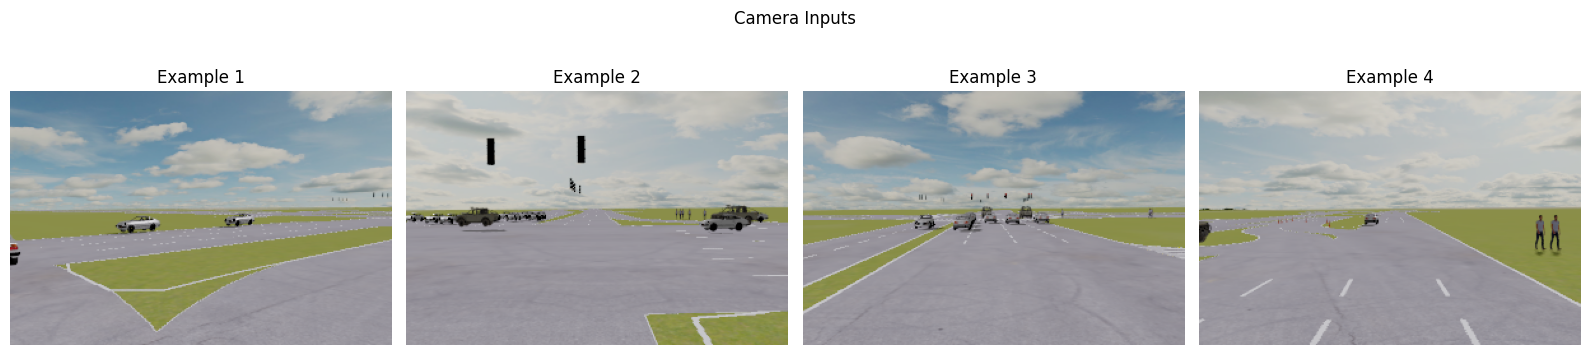

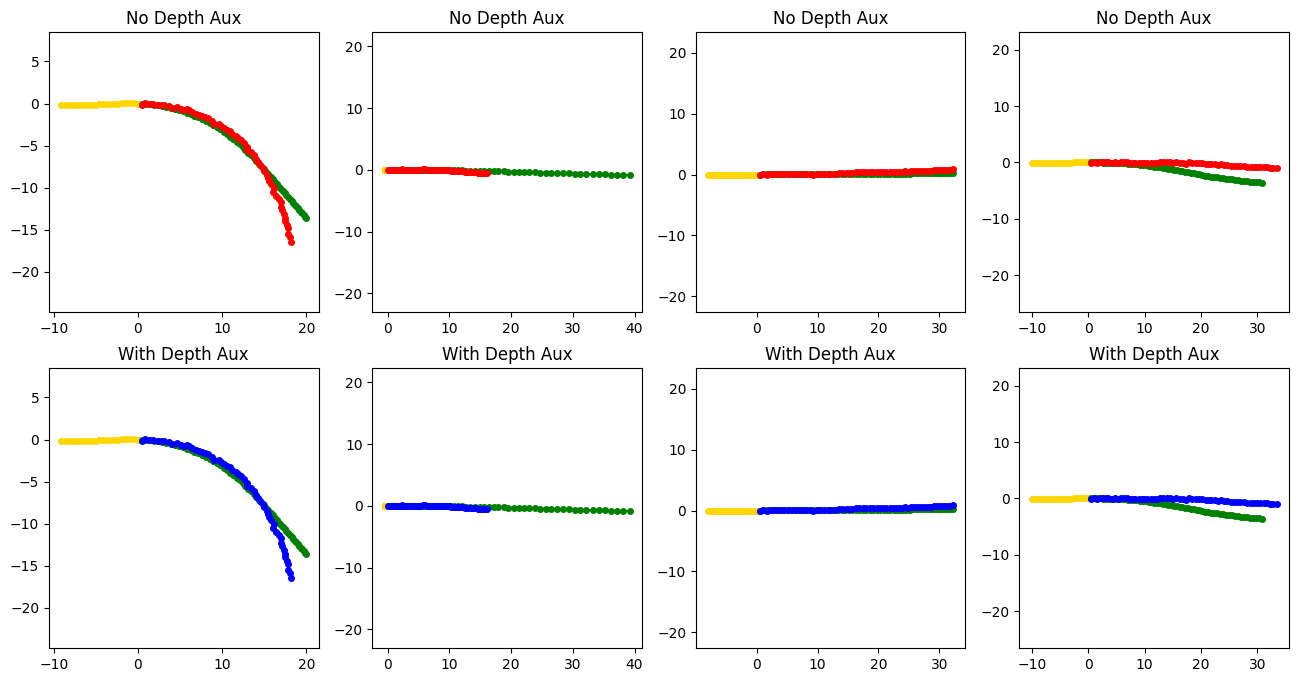

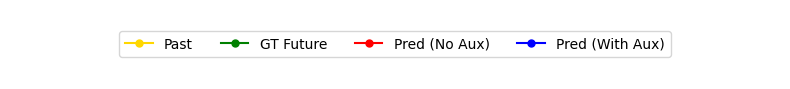

<Figure size 640x480 with 0 Axes>

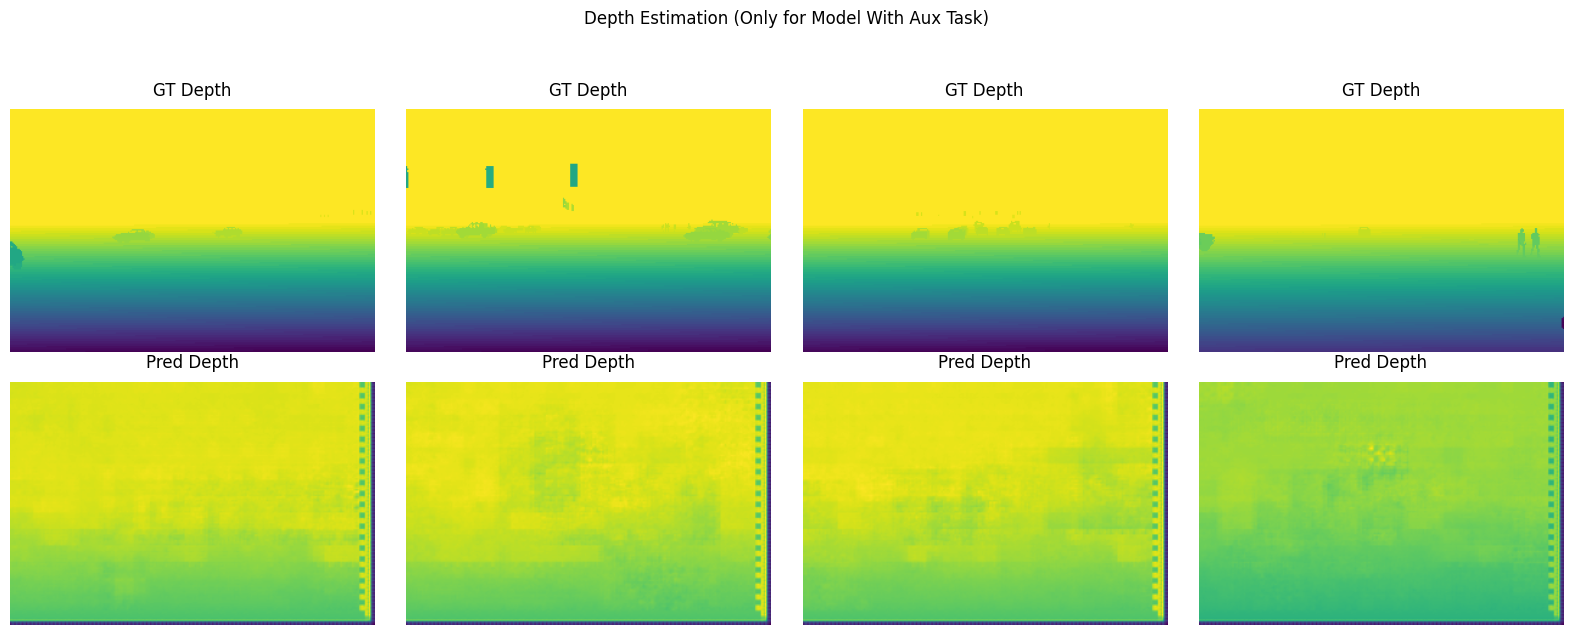

In [ ]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)

    with torch.no_grad():
        #pred_no_aux, _ = model_no_aux(camera, history, depth)
        pred_no_aux, _ = model_with_aux(camera, history, depth)
        pred_with_aux, pred_depth = model_with_aux(camera, history, depth)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model_no_aux, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
import pandas as pd

model = model_with_aux

test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        depth = batch['depth'].to(device)

        pred_future, _ = model(camera, history, depth)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
